<a href="https://colab.research.google.com/github/jdmartinev/MachineLearning/blob/main/Clase02/Notebooks/b_Penguins_RF_and_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación con Random Forest y Gradient Boosting

En este cuaderno aplicaremos ensambles de árboles de decisión tipo random forest y gradient boosting a un [dataset para predecir la especie de algunos pingüinos](https://www.openml.org/d/42585), usando validación cruzada para seleccionar buenos hiperparámetros.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

In [ ]:
# Definamos el "random_state" para que los resultados sean reproducibles:
random_state=42

In [ ]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

## Preprocesamiento de datos

In [ ]:
# Descarguemos nuestro dataset desde OpenML:

dataset = fetch_openml('penguins', as_frame=False)

data = pd.DataFrame(
    dataset.data,
    columns=dataset.feature_names
)

data['species'] = dataset.target

data

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species
0,2.0,39.1,18.7,181.0,3750.0,2.0,Adelie
1,2.0,39.5,17.4,186.0,3800.0,1.0,Adelie
2,2.0,40.3,18.0,195.0,3250.0,1.0,Adelie
3,2.0,NaN,NaN,NaN,NaN,NaN,Adelie
4,2.0,36.7,19.3,193.0,3450.0,1.0,Adelie
...,...,...,...,...,...,...,...
339,0.0,NaN,NaN,NaN,NaN,NaN,Gentoo
340,0.0,46.8,14.3,215.0,4850.0,1.0,Gentoo
341,0.0,50.4,15.7,222.0,5750.0,2.0,Gentoo
342,0.0,45.2,14.8,212.0,5200.0,1.0,Gentoo


In [ ]:
# Hallemos el número de datos faltantes en cada columna:
data.isna().sum()

island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
species               0
dtype: int64

In [ ]:
# Eliminemos las filas con datos faltantes:
data.dropna(axis=0, how='any', inplace=True)

In [ ]:
# Verifiquemos que ya no haya datos faltantes en ninguna columna:
data.isna().sum()

island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
species              0
dtype: int64

In [ ]:
# Analicemos la distribución de los valores de la columna `island`:
data['island'].value_counts()

0.0    164
1.0    123
2.0     47
Name: island, dtype: int64

In [ ]:
# Analicemos la distribución de los valores de la columna `sex`:
data['sex'].value_counts()

2.0    168
1.0    165
3.0      1
Name: sex, dtype: int64

In [ ]:
# Eliminemos la fila donde la columna `sex` es igual a 3:
data.drop(index=data[data['sex'] == 3.0].index, inplace=True)

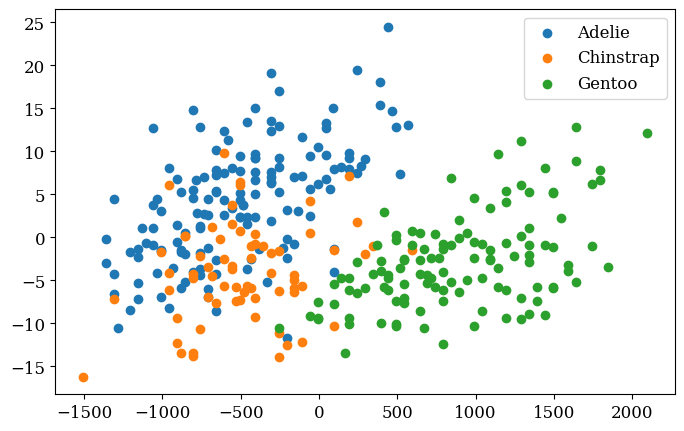

In [ ]:
# Visualicemos los datos reducidos a dos dimensiones:

data.reset_index(drop=True, inplace=True)

pca = PCA(2)
z = pca.fit_transform(data.drop(columns='species'))

fig, ax = plt.subplots()
for label in data['species'].unique():
    ax.scatter(
        z[data[data['species'] == label].index, 0],
        z[data[data['species'] == label].index, 1],
        label=label
    )
ax.legend()
fig.set_size_inches(1.6*5, 5)

In [ ]:
# Analicemos la distribución de los valores de la etiqueta `species`:
data['species'].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

In [ ]:
# Separemos nuestros datos en conjuntos de entrenamiento y prueba:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns='species'),
    data['species'],
    test_size=0.2,
    stratify=data['species'],
    random_state=random_state
)

In [ ]:
X_train

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
261,0.0,44.9,13.3,213.0,5100.0,1.0
199,1.0,50.7,19.7,203.0,4050.0,2.0
327,0.0,48.8,16.2,222.0,6000.0,2.0
117,2.0,41.4,18.5,202.0,3875.0,2.0
33,1.0,37.6,19.3,181.0,3300.0,1.0
...,...,...,...,...,...,...
19,0.0,38.8,17.2,180.0,3800.0,2.0
195,1.0,49.8,17.3,198.0,3675.0,1.0
38,1.0,44.1,19.7,196.0,4400.0,2.0
248,0.0,48.4,16.3,220.0,5400.0,2.0


In [ ]:

# Defineamos los modelos base (un random forest y un gradient boosting):
rf_base = RandomForestClassifier(random_state=random_state)
gb_base = GradientBoostingClassifier(random_state=random_state)

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': list(range(2, 8)),
    'classifier__min_samples_leaf': [1, 10, 50]
}

pipeline_rf = Pipeline(steps = [
    ('classifier', rf_base),
                            ])

pipeline_gb = Pipeline(steps = [
    ('classifier', gb_base),
    ])

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)


In [ ]:
%%time
# Entrenemos el random forest:
rf.fit(X_train, y_train)
# Entrenemos el gradient boosting:
gb.fit(X_train, y_train)

CPU times: user 50.9 s, sys: 219 ms, total: 51.1 s
Wall time: 55.5 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [2, 3, 4, 5, 6, 7],
                         'classifier__min_samples_leaf': [1, 10, 50],
                         'classifier__n_estimators': [50, 100]})

In [ ]:
# Obtengamos los mejores hiperparámetros encontrados para el random forest:
rf.best_params_

{'classifier__max_depth': 7,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 100}

In [ ]:
# Obtengamos los mejores hiperparámetros encontrados para el gradient boosting:
gb.best_params_

{'classifier__max_depth': 4,
 'classifier__min_samples_leaf': 10,
 'classifier__n_estimators': 100}

In [ ]:
# Obtengamos la accuracy y el F1 score de entrenamiento para cada modelo:
print("Training set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'Accuracy: {model.score(X_train, y_train)}')
    print(f"F1 score: {f1_score(y_train, model.predict(X_train), average='macro')}")
    print('\n')

Model: Random Forest
Accuracy: 1.0
F1 score: 1.0


Model: Gradient Boosting
Accuracy: 1.0
F1 score: 1.0




In [ ]:
# Obtengamos la accuracy y el F1 score de prueba para cada modelo:
print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'Accuracy: {model.score(X_test, y_test)}')
    print(f"F1 score: {f1_score(y_test, model.predict(X_test), average='macro')}")
    print('\n')

Test set
Model: Random Forest
Accuracy: 1.0
F1 score: 1.0


Model: Gradient Boosting
Accuracy: 0.9850746268656716
F1 score: 0.9826577939100626




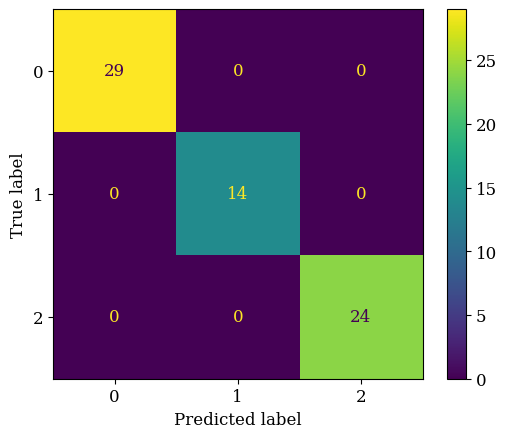

In [ ]:
# Grafiquemos la matriz de confusión del random foresr para los datos de prueba (sin normalizar):
cm = confusion_matrix(y_test,rf.predict(X_test))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

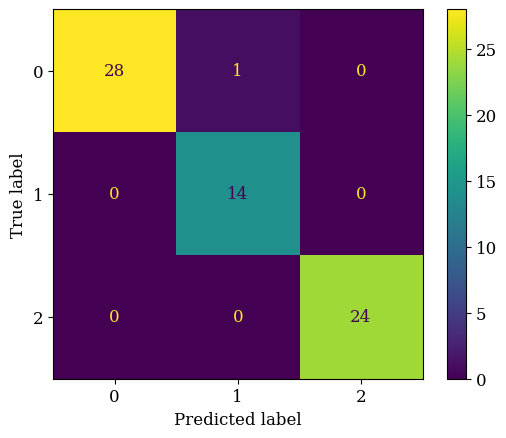

In [ ]:
# Grafiquemos la matriz de confusión del gradient boosting para los datos de prueba (sin normalizar):
cm = confusion_matrix(y_test,gb.predict(X_test))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [ ]:
# Veamos los datos junto con las predicciones de ambos modelos:
pd.concat([
    data.reset_index(drop=True),
    pd.DataFrame({'rf_predicted_species': rf.predict(data.drop(columns='species'))}),
    pd.DataFrame({'gb_predicted_species': gb.predict(data.drop(columns='species'))})
], axis=1)

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species,rf_predicted_species,gb_predicted_species
0,2.0,39.1,18.7,181.0,3750.0,2.0,Adelie,Adelie,Adelie
1,2.0,39.5,17.4,186.0,3800.0,1.0,Adelie,Adelie,Adelie
2,2.0,40.3,18.0,195.0,3250.0,1.0,Adelie,Adelie,Adelie
3,2.0,36.7,19.3,193.0,3450.0,1.0,Adelie,Adelie,Adelie
4,2.0,39.3,20.6,190.0,3650.0,2.0,Adelie,Adelie,Adelie
...,...,...,...,...,...,...,...,...,...
328,0.0,47.2,13.7,214.0,4925.0,1.0,Gentoo,Gentoo,Gentoo
329,0.0,46.8,14.3,215.0,4850.0,1.0,Gentoo,Gentoo,Gentoo
330,0.0,50.4,15.7,222.0,5750.0,2.0,Gentoo,Gentoo,Gentoo
331,0.0,45.2,14.8,212.0,5200.0,1.0,Gentoo,Gentoo,Gentoo
